## Antiguo proyecto de Redes Neuronales Recurrentes usando audios .wav, obteniendo su MFCC, aplicandolos a una RNN y validandolo con k fold cross validation

#### Librerias

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
import os
import soundfile as sf
import json
import random
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

from keras import Sequential
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
random.seed(0)

#### Funciones a usar

In [2]:
#Obtiene el path con el nombre de todos los archivos de un directorio.
def get_files_from_path(directory):
    path_files = []
    dir_list = os.listdir(directory)
    for path in dir_list:
        path_files.append(directory+"\\"+path)
    return path_files


#Extrae los paths que cumplan con un codigo
def extract_paths_for_emotions_keys(emotions_code, files_path, get_code):
    paths = []
    emotions_set = set(emotions_code)
    for code_file in files_path:
        if (get_code(code_file) in emotions_set):
            paths.append(code_file)
    return paths


#Obtiene el codigo en el nombre del archivo para el dataset CREMA-D
def get_code_crema_d(path):
    return path[119:122]


#Obtiene el codigo en el nombre del archivo para el dataset SAVEE
def get_code_savee(path):
    return path[108]


#Esta función abre el archivo .wav y obtiene el mfcc escalado en un vector de 40 elementos.
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
    #mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_features


#Esta función permite guardar los MFCC en 'features', el código en 'code' y su dirección en 'path' en un archivo json. 
def save_elements_in_json(examples_saved, name):
    json_files = []
    json_file = {}
    index = 0
    for file in examples_saved:
        json_file = {"id": index, "features":[str(elem) for elem in file[0]] ,"code":file[1], "path":file[2]}
        json_files.append(json_file)
        index += 1
    json_object = json.dumps(json_files)
    with open(f"{name}.json", "w") as outfile:
        outfile.write(json_object)
   

#La función permite cargar datos del MFCC y código desde un archivo json.
def load_elements_from_json(name):
    f = open(f'{name}.json')
    data = json.load(f)
    examples = []
    for element in data:
        examples.append(([float(feature) for feature in (element["features"])], element["code"]))
    return examples


#La función nos permite devolver una lista de MFCC obtenidos de una lista de paths. 
#El MFCC tiene un límite que no le permite cargar archivos menor o igual a 44 kb.
#Con el diccionario obtenemos el total de audios recuperados por emoción.
def get_features(paths,get_code, files_filters = dict()):
    examples = []
    for path in paths:
        code = get_code(path)
        file_stats = os.stat(path)
        if (file_stats.st_size > 44):
            feature = features_extractor(path)
            files_filters[code]+= 1
            examples.append((feature,code))
    print(f"Se obtuvo el MFCC de unos {len(paths)} sobre {sum(files_filters[files] for files in files_filters)} audios.")
    return examples


#Selecciona n ejemplos que necesitemos y los mezcla.
def select_elements(examples, code, quantity, new_code):
    random.shuffle(examples)
    elements = []
    counter = 1
    for example in examples:
        if (counter > quantity):
            break
        if code == example[1]:
            elements.append((example[0],new_code))
            counter = counter + 1
    return elements

Los siguientes bloques obtienen los paths y filtra las emociones que necesitemos en cada dataset (CREMA-D y SAVEE).

#### Funciones para obtener los datos 

In [3]:
#Obtiene todos los datos de CREMA-D y SAVEE para un  
def get_datas():
    files_path = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\AudioWav")
    emotions_code = ["NEU", "FEA","ANG"]
    datas_files = extract_paths_for_emotions_keys(emotions_code, files_path, get_code_crema_d)
    files_path_s = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\ALL")
    emotions_code_s = ["a", "f","n"]
    datas_files_s = extract_paths_for_emotions_keys(emotions_code_s, files_path_s, get_code_savee) 
    examples = []
    files_filters = dict()
    files_filters["NEU"] = 0
    files_filters["FEA"] = 0
    files_filters["ANG"] = 0
    files_filters["a"] = 0
    files_filters["f"] = 0
    files_filters["n"] = 0
    examples = get_features(datas_files, get_code_crema_d, files_filters)
    examples_s = get_features(datas_files_s, get_code_savee, files_filters)
    return examples + examples_s

#Obtiene los datos de entrada para la red neuronal x: mfcc normalizados, y: labeles categorizados
def get_entries():
    all_examples = get_datas()
    entries = []
    for example in all_examples:
        simplified = [i[:20] for i in example[0]]
        entries.append((simplified, example[1]))
    datas = select_elements(entries, 'NEU', 1086,"without_stress")
    datas += select_elements(entries, 'ANG', 543, "stress")
    datas += select_elements(entries, 'FEA', 543, "stress")
    datas += select_elements(entries, 'a', 60, "stress")
    datas += select_elements(entries, 'f', 60, "stress")
    datas += select_elements(entries, 'n', 120, "without_stress")   
    '''
    datas = select_elements(entries, 'NEU', 1087,"without_stress")
    datas += select_elements(entries, 'ANG', 1271, "stress")
    datas += select_elements(entries, 'FEA', 1270, "stress")
    datas += select_elements(entries, 'a', 60, "stress")
    datas += select_elements(entries, 'f', 60, "stress")
    datas += select_elements(entries, 'n', 120, "without_stress")   
    '''
    random.shuffle(datas)
    X = []
    y = []
    for data in datas:
        X.append(data[0])
        y.append(data[1])
    labelencoder=preprocessing.LabelEncoder()
    y = to_categorical(labelencoder.fit_transform(y))
    return X, y

#Obtiene los datos divididos de entrenamiento y tests
def obtain_datas_train_and_test(percentage):
    X, y = get_entries()
    X_test, X_train, y_test, y_train = train_test_split(X, y, test_size =percentage,random_state=0)
    y = np.array(y)
    '''
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    '''
    return X_train, X_test, y_train, y_test

In [52]:
X_train, X_test, y_train, y_test = obtain_datas_train_and_test(0.8)
X_train = np.squeeze(np.asarray(X_train))
X_test = np.squeeze(np.asarray(X_test))
y_train = np.squeeze(np.asarray(y_train))
y_test = np.squeeze(np.asarray(y_test))

num_labels = y_train.shape[1] + y_test.shape[1]
#dim_entrada = (X_train.shape[1],1)

Se obtuvo el MFCC de unos 3629 sobre 3628 audios.
Se obtuvo el MFCC de unos 240 sobre 3868 audios.


In [45]:
dim_entrada = len(X_train[0]),len(X_train[0][0])

In [46]:
dim_entrada

(40, 20)

In [47]:

def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(units=20,input_shape= dim_entrada, return_sequences=True))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(units=10,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

In [67]:
model = new_RNN()
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 40, 50)            10400     
                                                                 
 activation_52 (Activation)  (None, 40, 50)            0         
                                                                 
 dropout_52 (Dropout)        (None, 40, 50)            0         
                                                                 
 lstm_54 (LSTM)              (None, 40, 20)            5680      
                                                                 
 activation_53 (Activation)  (None, 40, 20)            0         
                                                                 
 dropout_53 (Dropout)        (None, 40, 20)            0         
                                                                 
 lstm_55 (LSTM)              (None, 10)              

In [63]:
for train, test in k_fold.split(X):
    print(test)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [65]:
X[0].shape

(40, 20)

In [74]:
k_fold = KFold(5)
fold = 0
y_tests = []
predictions = []
scores = []
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
for train, test in k_fold.split(X):
    fold = fold + 1
    print(f"Fold #{fold}")
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    print(f"Train - X:{X_train.shape} y:{y_train.shape}")
    print(f"Test - X:{X_test.shape} y:{y_test.shape}")
    
    num_labels = y.shape[1]
    dim_entrada = (X_train.shape[1],X_train.shape[2])
    print(num_labels)
    print(dim_entrada)
    #model = new_RNN()
    model = new_RNN()
    callbacks = []
    '''
    callbacks = [
    EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=20,
            verbose=1,
        )
    ]
    '''
    num_epochs = 50
    num_batch_size = 32
    start = datetime.datetime.now()
   
    results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)

    pred = model.predict(X_test)
    y_tests.append(y_test)
    pred=[([1,0] if i[0]>i[1] else [0,1]) for i in pred]
    predictions.append(pred)
    score = metrics.accuracy_score(pred, y_test)
    math = confusion_matrix([(1 if x[0]==1 else 0) for x in pred],[(1 if x[0]==1 else 0) for x in y_test], labels=[1,0])
    scores.append([score])
    print(f"Fold score (Accuracy score): {score}")
    print("Matriz de confusion")
    print("-------------------")
    print("---------| Verdadero | Falso |")
    print(f"Verdadero|  {math[0][0]}        {math[0][1]}")
    print(f"Falso    |  {math[1][0]}        {math[1][1]}")

y_tests = np.concatenate(y_tests)
predictions = np.concatenate(predictions)
score = metrics.accuracy_score(predictions, y_tests)
print("-----------------------")
print(f"Cross-validated score (Accuracy score): {score}")
print("-----------------------")
print("Resumen")
for result in scores:
    print(f"Fold score (Accuracy score): {result[0]}")
    
#https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_2_kfold.ipynb
#https://www.youtube.com/watch?v=maiQf8ray_s

Fold #1
Train - X:(1929, 40, 20) y:(1929, 2)
Test - X:(483, 40, 20) y:(483, 2)
2
(40, 20)
Epoch 1/50
61/61 [==============================] - 81s 171ms/step - loss: 0.6929 - accuracy: 0.5049 - val_loss: 0.6897 - val_accuracy: 0.5714
Epoch 2/50
61/61 [==============================] - 7s 116ms/step - loss: 0.6905 - accuracy: 0.5288 - val_loss: 0.6859 - val_accuracy: 0.6149
Epoch 3/50
61/61 [==============================] - 8s 123ms/step - loss: 0.6736 - accuracy: 0.5858 - val_loss: 0.6386 - val_accuracy: 0.6542
Epoch 4/50
61/61 [==============================] - 6s 93ms/step - loss: 0.6424 - accuracy: 0.6475 - val_loss: 0.6186 - val_accuracy: 0.6667
Epoch 5/50
61/61 [==============================] - 6s 91ms/step - loss: 0.6104 - accuracy: 0.6853 - val_loss: 0.6002 - val_accuracy: 0.6791
Epoch 6/50
61/61 [==============================] - 6s 94ms/step - loss: 0.5861 - accuracy: 0.7019 - val_loss: 0.5901 - val_accuracy: 0.6894
Epoch 7/50
61/61 [==============================] - 6s 96ms/

Epoch 6/50
61/61 [==============================] - 5s 84ms/step - loss: 0.5853 - accuracy: 0.6682 - val_loss: 0.5581 - val_accuracy: 0.7226
Epoch 7/50
61/61 [==============================] - 5s 81ms/step - loss: 0.5687 - accuracy: 0.6838 - val_loss: 0.6023 - val_accuracy: 0.6667
Epoch 8/50
61/61 [==============================] - 5s 74ms/step - loss: 0.5636 - accuracy: 0.6993 - val_loss: 0.5600 - val_accuracy: 0.7101
Epoch 9/50
61/61 [==============================] - 6s 95ms/step - loss: 0.5456 - accuracy: 0.7252 - val_loss: 0.5605 - val_accuracy: 0.7205
Epoch 10/50
61/61 [==============================] - 6s 106ms/step - loss: 0.5413 - accuracy: 0.7351 - val_loss: 0.5553 - val_accuracy: 0.7350
Epoch 11/50
61/61 [==============================] - 6s 106ms/step - loss: 0.5291 - accuracy: 0.7413 - val_loss: 0.5744 - val_accuracy: 0.7205
Epoch 12/50
61/61 [==============================] - 6s 102ms/step - loss: 0.5309 - accuracy: 0.7460 - val_loss: 0.5715 - val_accuracy: 0.7164
Epoch 1

61/61 [==============================] - 7s 109ms/step - loss: 0.5283 - accuracy: 0.7591 - val_loss: 0.5939 - val_accuracy: 0.6680
Epoch 12/50
61/61 [==============================] - 6s 106ms/step - loss: 0.5285 - accuracy: 0.7570 - val_loss: 0.5898 - val_accuracy: 0.6992
Epoch 13/50
61/61 [==============================] - 6s 101ms/step - loss: 0.5101 - accuracy: 0.7668 - val_loss: 0.5880 - val_accuracy: 0.6950
Epoch 14/50
61/61 [==============================] - 7s 112ms/step - loss: 0.4995 - accuracy: 0.7767 - val_loss: 0.6063 - val_accuracy: 0.6888
Epoch 15/50
61/61 [==============================] - 7s 112ms/step - loss: 0.4934 - accuracy: 0.7772 - val_loss: 0.6273 - val_accuracy: 0.6805
Epoch 16/50
61/61 [==============================] - 6s 104ms/step - loss: 0.4892 - accuracy: 0.7907 - val_loss: 0.6497 - val_accuracy: 0.6763
Epoch 17/50
61/61 [==============================] - 6s 102ms/step - loss: 0.4883 - accuracy: 0.7772 - val_loss: 0.5841 - val_accuracy: 0.7075
Epoch 18/50

61/61 [==============================] - 8s 124ms/step - loss: 0.4877 - accuracy: 0.7829 - val_loss: 0.6100 - val_accuracy: 0.6971
Epoch 17/50
61/61 [==============================] - 7s 120ms/step - loss: 0.4692 - accuracy: 0.7917 - val_loss: 0.6293 - val_accuracy: 0.6743
Epoch 18/50
61/61 [==============================] - 7s 119ms/step - loss: 0.4731 - accuracy: 0.7933 - val_loss: 0.6215 - val_accuracy: 0.6846
Epoch 19/50
61/61 [==============================] - 7s 121ms/step - loss: 0.4584 - accuracy: 0.7979 - val_loss: 0.6232 - val_accuracy: 0.7116
Epoch 20/50
61/61 [==============================] - 7s 122ms/step - loss: 0.4436 - accuracy: 0.8109 - val_loss: 0.6739 - val_accuracy: 0.6743
Epoch 21/50
61/61 [==============================] - 8s 124ms/step - loss: 0.4354 - accuracy: 0.8135 - val_loss: 0.6651 - val_accuracy: 0.6701
Epoch 22/50
61/61 [==============================] - 8s 123ms/step - loss: 0.4047 - accuracy: 0.8150 - val_loss: 0.6238 - val_accuracy: 0.6867
Epoch 23/50

61/61 [==============================] - 15s 252ms/step - loss: 0.4392 - accuracy: 0.7943 - val_loss: 0.6947 - val_accuracy: 0.6846
Epoch 22/50
61/61 [==============================] - 15s 240ms/step - loss: 0.4601 - accuracy: 0.7782 - val_loss: 0.6634 - val_accuracy: 0.6743
Epoch 23/50
61/61 [==============================] - 15s 246ms/step - loss: 0.4209 - accuracy: 0.7948 - val_loss: 0.7517 - val_accuracy: 0.6805
Epoch 24/50
61/61 [==============================] - 16s 261ms/step - loss: 0.4147 - accuracy: 0.8016 - val_loss: 0.6863 - val_accuracy: 0.6826
Epoch 25/50
61/61 [==============================] - 15s 246ms/step - loss: 0.3991 - accuracy: 0.8145 - val_loss: 0.6969 - val_accuracy: 0.6701
Epoch 26/50
61/61 [==============================] - 16s 261ms/step - loss: 0.4099 - accuracy: 0.8000 - val_loss: 0.7155 - val_accuracy: 0.6743
Epoch 27/50
61/61 [==============================] - 17s 273ms/step - loss: 0.4035 - accuracy: 0.8062 - val_loss: 0.8025 - val_accuracy: 0.6701
Epoc

In [49]:
#50 0.77
model = new_RNN()
model.summary()
#https://keras.io/api/callbacks/early_stopping/
callbacks = []

callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        min_delta=0.01, #si un epochs mejora como un min_delta respecto a la anterior, no contara como mejora
        patience=70,#numero de epochs sin mejoras que se tendra paciencia
        verbose=1,#mostrar informacion extra, 0 no mostrar
     )
]

num_epochs = 100
num_batch_size = 32
start = datetime.datetime.now()
   
results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)
duration = datetime.datetime.now() - start
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")
y_values = model.predict(X_test)
y_prediction=[([1,0] if i[0]>i[1] else [0,1]) for i in y_values]
y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 40, 50)            14200     
                                                                 
 activation_19 (Activation)  (None, 40, 50)            0         
                                                                 
 dropout_19 (Dropout)        (None, 40, 50)            0         
                                                                 
 lstm_21 (LSTM)              (None, 40, 20)            5680      
                                                                 
 activation_20 (Activation)  (None, 40, 20)            0         
                                                                 
 dropout_20 (Dropout)        (None, 40, 20)            0         
                                                                 
 lstm_22 (LSTM)              (None, 10)               

61/61 [==============================] - 5s 86ms/step - loss: 0.1626 - accuracy: 0.9399 - val_loss: 1.4133 - val_accuracy: 0.6432
Epoch 47/100
61/61 [==============================] - 5s 85ms/step - loss: 0.1447 - accuracy: 0.9487 - val_loss: 1.3825 - val_accuracy: 0.6224
Epoch 48/100
61/61 [==============================] - 5s 82ms/step - loss: 0.1339 - accuracy: 0.9565 - val_loss: 1.5509 - val_accuracy: 0.6390
Epoch 49/100
61/61 [==============================] - 4s 72ms/step - loss: 0.1224 - accuracy: 0.9575 - val_loss: 1.6812 - val_accuracy: 0.6183
Epoch 50/100
61/61 [==============================] - 5s 78ms/step - loss: 0.1078 - accuracy: 0.9622 - val_loss: 1.6690 - val_accuracy: 0.6411
Epoch 51/100
61/61 [==============================] - 5s 84ms/step - loss: 0.1177 - accuracy: 0.9591 - val_loss: 1.6139 - val_accuracy: 0.6245
Epoch 52/100
61/61 [==============================] - 5s 85ms/step - loss: 0.1375 - accuracy: 0.9513 - val_loss: 1.6151 - val_accuracy: 0.6286
Epoch 53/100

In [32]:
training_loss = results.history['loss']
test_loss = results.history['val_loss']
epochs_range = range(1, len(training_loss) + 1)

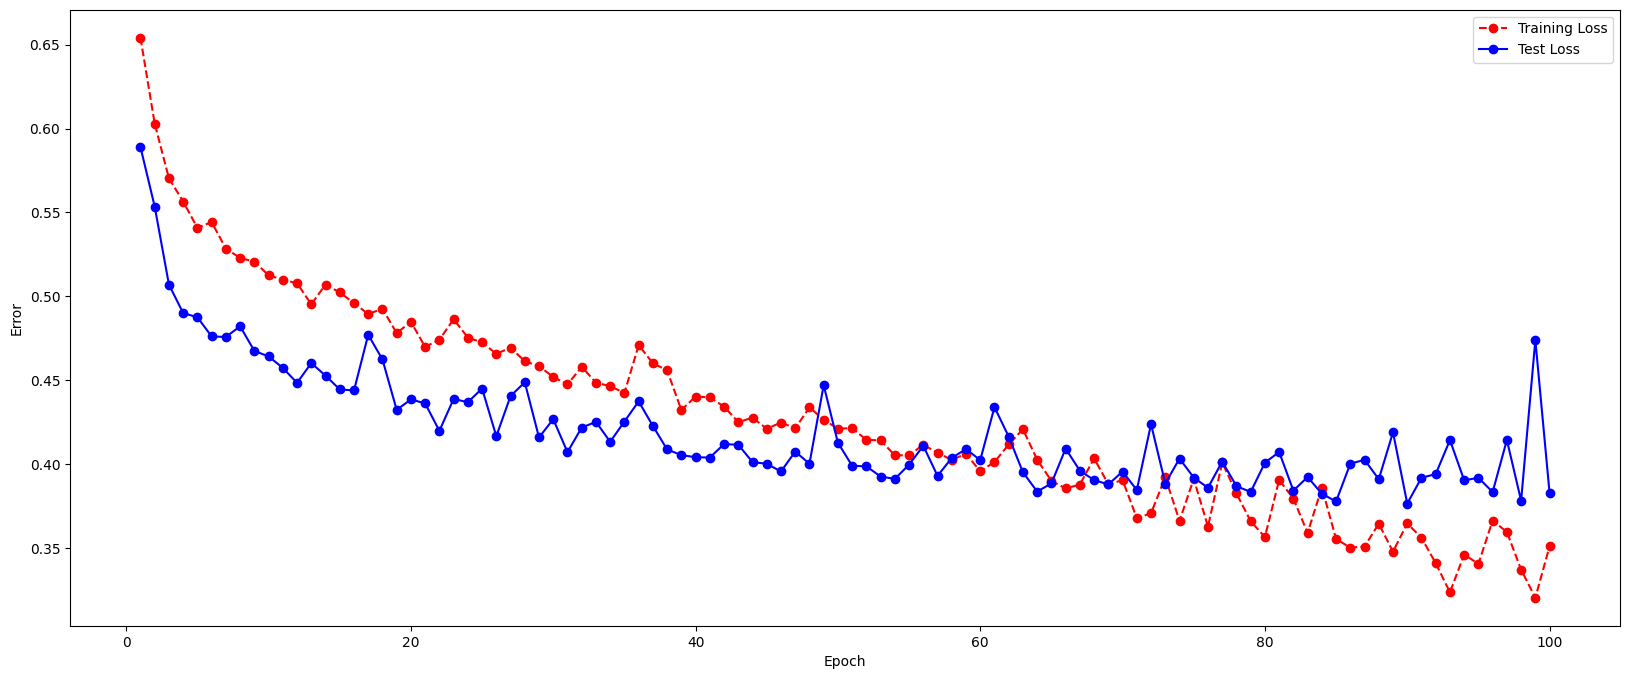

In [33]:
plt.plot(epochs_range, training_loss, 'r',marker="o",linestyle="--")
plt.plot(epochs_range, test_loss, 'b',marker="o",linestyle="-")
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.rcParams["figure.figsize"] = (20,8)
plt.show()

In [14]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")

y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
    
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

val_loss: 0.40328726172447205 val_accuracy: 0.8150064945220947


NameError: name 'y_values' is not defined

In [77]:
'''
val_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128
val_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128
val_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808
'''

'\nval_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128\nval_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128\nval_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808\n'

#### Crossvalidation

In [57]:
X = np.array(X)
y = np.array(y)
print(f"X:{X.shape} y:{y.shape}")

X:(2236, 40) y:(2236, 2)


In [69]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


El bloque realizara el k fold cross validation dividiendolo en 5 folds, se uso los MSE.

In [28]:
# serialize model to JSON
model_json = model.to_json()
with open("model_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_5.h5")
print("Saved model to disk")

Saved model to disk
